In [210]:
import numpy as np
import pandas as pd
import torchvision.io as io
import matplotlib.pyplot as plt
import torchaudio
import torch
import torch.nn as nn

In [223]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print(f"Sample Rate: {bundle.sample_rate}")
print(f"Labels: {bundle.get_labels()}")
model = bundle.get_model().to(device)
print(model.__class__)

Using device cuda
Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [224]:
waveform, sample_rate = torchaudio.load("dataset/audios/M003_angry_level_2_028.wav")
vid = io.read_video(f"temp/data/M003_front_angry_level_1_001.mp4", pts_unit="sec", output_format="TCHW")[0][:60]
target =  torch.from_numpy(np.load(f"temp/data/M003_front_angry_level_1_001.npy")).permute(2,0,1)[:,:60]
waveform = waveform.to(device)
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    waveform = waveform[:, :bundle.sample_rate * 2]
with torch.inference_mode():
    emission, _ = model(waveform)


print(f"Video shape: {vid.shape}")
print(f"Input shape: {waveform.shape}")
print("-"*30)
print(f"Target shape: {target.shape}")
print(f"Vec shape: {emission.shape}")


Video shape: torch.Size([60, 3, 256, 256])
Input shape: torch.Size([2, 32000])
------------------------------
Target shape: torch.Size([2, 60, 478])
Vec shape: torch.Size([2, 99, 29])


## Model

In [225]:
cvt1 = nn.Conv1d(in_channels=99, out_channels=60, kernel_size=1).to('cuda')
cvt2 = nn.Linear(in_features=29, out_features=512, bias=True).to('cuda')
transformer_model = nn.Transformer(nhead=2, num_encoder_layers=8).to('cuda')
cvb = nn.Linear(in_features=512, out_features=478, bias=True).to('cuda')

In [226]:
with torch.no_grad(): 
    x = cvt1(emission)
    x = cvt2(x)
    x = transformer_model(x,x)
    x = cvb(x)
    y = torch.sigmoid(x)


y.shape

torch.Size([2, 60, 478])

In [227]:
target.shape

torch.Size([2, 60, 478])

## Plot

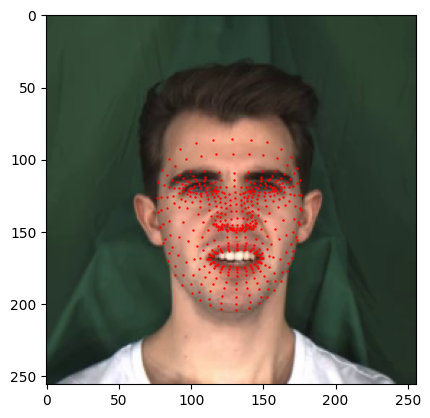

In [228]:
import matplotlib.pyplot as plt
plt.imshow(vid[0].permute(1,2,0))
target = target.permute(1,2,0)
plt.scatter(target[0][:,0]*256, target[0][:,1]*256,  c='r',s=0.5)
plt.show()



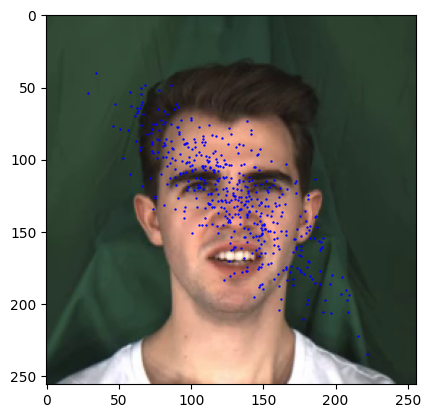

In [229]:
plt.imshow(vid[0].permute(1,2,0))
y = y.permute(1,2,0).cpu().numpy()
plt.scatter(y[0][:,0]*256, y[0][:,1]*256,  c='b',s=0.5)
plt.show()


## Dataloader

In [21]:
import torch
import torchaudio
from torch.utils.data import Dataset
import json
import numpy as np
import pandas as pd
import torchvision.io as io

In [26]:
class MEAD(Dataset):
    def __init__(self, data_path):
        super(MEAD, self).__init__()

        with open(data_path,"r") as f:
            self.datalist = json.load(f)
        self.time = 2

    def __len__(self):
        return len(self.datalist)
    
    def __getitem__(self, idx):
        row = self.datalist[idx]
        vid = f"{row['video']}".replace("/", "_").replace("video_", "")
        aud = vid.replace("_front", "").replace('.mp4','.wav')
        lm = aud.replace('.mp4','.wav')

        video = io.read_video(f"dataset/vidcrops/{aud}", pts_unit="sec", output_format="TCHW")[0][:30*self.time]
        waveform, sample_rate = torchaudio.load(f"dataset/audios/{aud}")
        landmark =  torch.from_numpy(np.load(f"dataset/mp_landmarks/{aud.replace('.mp4','.npy')}")).permute(2,0,1)[:,:60]
        if sample_rate != bundle.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
            waveform = waveform[:, :bundle.sample_rate * 2]

        return {'video': video, 'waveform': waveform, 'landmark': landmark}


